# Test the pipeline with the Hungarian Kalman Filter (WKF).

In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get the path of the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.filters.hungarian_extended_kalman_filter_2 import HungarianExtendedKalmanFilter

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12


In [2]:
from scipy.special import factorial

def function_f(x, dt):
    """ Non-linear state transition function for a sine-like model."""
    x_next =np.zeros_like(x, dtype=np.float64)
    x_next[0] = x[0]
    x_next[1] = x[1]
    x_next[2] = x[2] + dt * x[1]
    return x_next

def function_h(x, dt):
    """ Non-linear observation function for a sine-like model."""
    y = x[0] * np.sin(x[2])
    return y

def build_A_matrix(x, dt):
    """Build state linearized transition matrix A for a sine-like model."""
    A = np.eye(3, dtype=np.float64)
    A[2, 1] = dt
    return A

def build_H_matrix(x, dt):
    """Build observation matrix H for a sine-like model."""
    H = np.array([[np.sin(x[2]), 0, x[0]*np.cos(x[2])]], dtype=np.float64)
    return H

def build_Q_matrix(dt, sigma_a, sigma_phi_a):
    """
    Build process noise covariance matrix Q for the state [p, p_dot, omega, b].

    - q: spectral density of white acceleration noise (for [p, p_dot] block)
    - sigma_w: variance of frequency noise (for omega random walk)
    - sigma_b: variance of offset noise (for b random walk)
    """
    Q = np.zeros((3, 3), dtype=np.float64)

    # Correct continuous white-acceleration model for [p, p_dot]
    Q[0, 0] = dt * sigma_a**2
    Q[1, 1] = dt * sigma_phi_a**2
    Q[1, 2] = dt**2/2 * sigma_phi_a**2
    Q[2, 1] = dt**2/2 * sigma_phi_a**2
    Q[2, 2] = dt**3/3 * sigma_phi_a**2

    return Q

def build_P_matrix(num_traces, dt, P_0_vector):
    """Build initial state covariance matrix P with increasing uncertainty."""
    P_patern = np.array([[P_0_vector[0]**2, 0, 0],
                        [0, P_0_vector[1]**2, 0],
                        [0, 0, P_0_vector[2]**2]])
    P = np.array([np.copy(P_patern) for _ in range(num_traces)]) * dt
    return P

def evaluate_sources_rmse_gridsearch(
    Dts, sigma_as, sigma_phi_as, sigma_zs, function_f, sources_train, sources_eval, selected, N_traces, 
    a_0, phi_0, omega_0, P_0_vector, ut="v1",
    batch_size=1, write_latex=False, latex_output_dir="output_2_traces/HEKF/overlap_0",
    success_threshold=20
):
    """
    Perform grid search on training sources, and evaluate best config on separate evaluation sources.

    Parameters:
    - Dts, qs, sigma_zs (list): Grid values for Kalman filter parameters.
    - sources_train (list): Sources used during grid search.
    - sources_eval (list): Sources to evaluate success rate with best parameters.
    - selected (str): Identifier for source name formatting.
    - N_traces (int): Number of traces per image.
    - ut (str): Unique identifier for run.
    - order (int): State model order.
    - batch_size (int): Batch size for evaluation.
    - write_latex (bool): Whether to generate LaTeX tables.
    - latex_output_dir (str): Path to write LaTeX files.
    - success_threshold (float): RMSE threshold for a "success".

    Returns:
    - best_params (dict): Best parameter set.
    - min_RMSE (float): Mean RMSE across training set.
    - min_RMSE_std (float): RMSE std across training set.
    - best_success_rate_train (float): % success (per-curve) on training set.
    - success_rates_eval (list of float): % success (per-curve) per source in sources_eval.
    - results_table (dict): Grid result dictionary with (RMSE, std, success).
    """
    results_table = defaultdict(lambda: defaultdict(dict))
    max_success_rate = 0.0
    best_params = {}

    # -------- GRID SEARCH (on sources_train) --------
    for Dt in tqdm(Dts, desc="Dt"):
        for sigma_z in sigma_zs:
            for sigma_a in sigma_as: 
                for sigma_phi_a in sigma_phi_as:
                    Q = build_Q_matrix(Dt, sigma_a, sigma_phi_a)
                    P = build_P_matrix(N_traces, Dt, P_0_vector)
                    R = np.array([[sigma_z**2]], dtype=np.float64)

                    all_curve_rmses = []

                    for source in sources_train:
                        image_folder_path = os.path.join(source, "signals")
                        GTs_folder_path = os.path.join(source, "ground_truth")

                        output_folder_path = None

                        _, _, curve_rmses = evaluate_filter(
                            image_folder_path, GTs_folder_path, output_folder_path,
                            HungarianExtendedKalmanFilter(build_H_matrix, Q, R, Dt, function_f, function_h, build_A_matrix),
                            P, batch_size=batch_size, step=1, save=False, a_0=a_0, omega_0=omega_0, phi_0=phi_0, forum=True
                        )

                        all_curve_rmses.extend(curve_rmses)

                    success_rate = np.mean(np.array(all_curve_rmses) <= success_threshold) * 100

                    results_table[sigma_phi_a][sigma_a][sigma_z] = success_rate

                    if success_rate > max_success_rate:
                        max_success_rate = success_rate
                        best_params = {'Dt': Dt, 'sigma_a': sigma_a, 'sigma_phi_a':sigma_phi_a, 'sigma_z': sigma_z}

    # -------- FINAL EVALUATION on sources_eval with best params --------
    success_rates_eval = []
    if best_params:
        Dt, sigma_a, sigma_phi_a, sigma_z = best_params['Dt'], best_params['sigma_a'], best_params['sigma_phi_a'], best_params['sigma_z']
        Q = build_Q_matrix(Dt, sigma_a, sigma_phi_a)
        P = build_P_matrix(N_traces, Dt, P_0_vector)
        R = np.array([[sigma_z**2]], dtype=np.float64)

        for source in sources_eval:
            print(source)
            image_folder_path = os.path.join(source, "signals")
            GTs_folder_path = os.path.join(source, "ground_truth")

            output_folder_path = os.path.join(
                source,
                f"eval_HEKF2_dt{Dt:.2f}_sigma_a{sigma_a:.2f}_sigma_phi_a_{sigma_phi_a:.2f}_sigma_z{sigma_z:.2f}_Ntraces{N_traces}_ut{ut}"
            )
            os.makedirs(output_folder_path, exist_ok=True)

            _, _, curve_rmses_eval = evaluate_filter(
                            image_folder_path, GTs_folder_path, output_folder_path,
                            HungarianExtendedKalmanFilter(build_H_matrix, Q, R, Dt, function_f, function_h, build_A_matrix),
                            P, batch_size=batch_size, step=1, labels = [r"$a$", r"$\omega$", r"$\phi$"], a_0=a_0, omega_0=omega_0, phi_0=phi_0, forum=True
                        )

            success_rate_eval = np.mean(np.array(curve_rmses_eval) <= success_threshold) * 100
            success_rates_eval.append(success_rate_eval)
            print(f"Success rate for {source}: {success_rate_eval:.2f}%")

    # -------- LaTeX TABLES (optional) --------
    if write_latex:
        os.makedirs(latex_output_dir, exist_ok=True)
        for sigma_phi_a in sigma_phi_as:
            latex = []
            latex.append(r"\begin{table}[H]")
            latex.append(r"\centering")
            latex.append(r"\begin{tabular}{c|" + "c" * len(sigma_zs) + "}")
            latex.append(r"$\sigma_a \backslash \sigma_z$ & " + " & ".join([f"{sigma:.2f}" for sigma in sigma_zs]) + r"\\")
            latex.append(r"\hline")

            for sigma_a in sigma_as:
                row = [f"{sigma_a:.2f}"]
                for sigma_z in sigma_zs:
                    entry = results_table[sigma_phi_a][sigma_a].get(sigma_z, None)
                    if entry is not None:
                        success = entry
                        row.append(f"{success:.1f}\\%")
                    else:
                        row.append("-")
                latex.append(" & ".join(row) + r"\\")

            latex.append(r"\end{tabular}")
            latex.append(rf"\caption{{RMSE and success rate (≤ {success_threshold}) for Dt = {Dt:.2f}, sigma_phi_a = {sigma_phi_a:.2f}, ut = {ut}}}")
            latex.append(rf"\label{{tab:rmse_sigma_phi_a_{str(sigma_phi_a).replace('.', '_')}_ut_{ut}}}")
            latex.append(r"\end{table}")

            file_path = os.path.join(latex_output_dir, f"RMSE_table_sigma_phi_a_{str(sigma_phi_a).replace('.', '_')}_ut_{ut}.tex")
            with open(file_path, "w") as f:
                f.write("\n".join(latex))

        print(f"LaTeX tables written to {latex_output_dir}")

    return best_params, max_success_rate, success_rates_eval

In [3]:
sources_eval_sines_2_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-00",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-06",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-11",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-17",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-22",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-28",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-33",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-39",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-44",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-50"]

sources_eval_resampled_2_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-00",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-06",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-11",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-17",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-22",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-33",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-39",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-44",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-50"]

sources_eval_resampled_5_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-00",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-06",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-11",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-17",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-22",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-33",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-39",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-44",
                                   r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-50"]

sources_eval_sines_5_curves = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-00",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-06",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-11",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-17",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-22",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-28",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-33",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-39",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-44",
                               r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-50"]

sources_eval_dic = {
    "sources_eval_sines_2_curves": sources_eval_sines_2_curves,
    "sources_eval_resampled_2_curves": sources_eval_resampled_2_curves,
    "sources_eval_resampled_5_curves": sources_eval_resampled_5_curves,
    "sources_eval_sines_5_curves": sources_eval_sines_5_curves
}

In [4]:
overlaps = np.array([0.00, 0.06, 0.11, 0.17, 0.22, 0.28, 0.33, 0.39, 0.44, 0.50])

# success_HEKF2 = np.zeros((len(overlaps))) # Shape (overlaps, num_methods, 2) 2 for sines and resampled
success_2_curves_HEKF = np.zeros((len(overlaps), 2)) # Shape (overlaps, num_methods, 1) 1 for sines
success_5_curves_HEKF = np.zeros((len(overlaps), 2)) # Shape (overlaps, num_methods, 1) 1 for sines

## Parameters

In [5]:
Dts = [0.2]#, 0.5, 0.9]

sigma_as = [0.1, 1, 10] # [0.01, 0.1, 1]
sigma_phi_as = [np.pi/10, np.pi] #[0.1, 2, 3] # [0.01, 0.1, 1]
sigma_zs = [0.1, 1, 10] # [0.1, 2, np.sqrt(5)] # [0.01, 0.1, 1]

# a_0 = 20
omega_0 = np.pi/2 # 0
phi_0 = 0 # np.pi/2

P_0_vector = np.array([1, np.pi/2, np.pi])

batch_size = 5
N_traces = 2

ut = "grid_corect"


# # Dts = [0.2, 0.02, 0.007] # [0.007/2]
# sigma_as = [0.7]
# sigma_phi_as = [0.7]
# sigma_zs = [1]

# P_0_vector = np.array([1, 1, 5])

# a_0 = 20
# omega_0 = np.pi/2
# phi_0 = 0


## Evaluate 2 curves

In [6]:
latex_output_dir = f"output_{N_traces}_traces/overlap_28"
selected = r"\data_{}_traces".format(N_traces)
sources_train = [
    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines\overlap_0-28"
]

best_params, best_success_rate_train, success_rates_eval = evaluate_sources_rmse_gridsearch(
    Dts, sigma_as, sigma_phi_as, sigma_zs, function_f=function_f,
    sources_train=sources_train,
    sources_eval=sources_eval_dic[r"sources_eval_sines_{}_curves".format(N_traces)] + sources_eval_dic[r"sources_eval_resampled_{}_curves".format(N_traces)],
    selected=selected,
    N_traces=N_traces,
    ut=ut,
    a_0=None, phi_0=phi_0, omega_0=omega_0, P_0_vector=P_0_vector,
    batch_size=batch_size,
    write_latex=True, 
    latex_output_dir=latex_output_dir,
    success_threshold=16.0
)

print("Best params:", best_params)
print("Best success rate train:", f"{best_success_rate_train:.1f}%")
print("Success rates eval:", success_rates_eval)

success_2_curves_HEKF[:, 0] = success_rates_eval[:len(overlaps)]
success_2_curves_HEKF[:, 1] = success_rates_eval[len(overlaps):]

Dt: 100%|██████████| 1/1 [04:45<00:00, 285.61s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-00
Success rate for D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-00: 100.00%
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-06
Success rate for D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-06: 90.00%
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-11
Success rate for D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-11: 55.00%
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-17
Success rate for D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\sines\overlap_0-17: 75.00%
D:\Courses\Uclouvain\thesis\code\thesis_Col

## Evaluate 5 curves

In [7]:
N_traces = 5

latex_output_dir = f"output_{N_traces}_traces/overlap_28"
selected = r"\data_{}_traces".format(N_traces)
sources_train = [
    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction" + selected + r"\sines\overlap_0-28"
]

best_params, best_success_rate_train, success_rates_eval = evaluate_sources_rmse_gridsearch(
    Dts, sigma_as, sigma_phi_as, sigma_zs, function_f=function_f,
    sources_train=sources_train,
    sources_eval=sources_eval_dic[r"sources_eval_sines_{}_curves".format(N_traces)] + sources_eval_dic[r"sources_eval_resampled_{}_curves".format(N_traces)],
    selected=selected,
    N_traces=N_traces,
    ut=ut,
    a_0=None, phi_0=phi_0, omega_0=omega_0, P_0_vector=P_0_vector,
    batch_size=batch_size,
    write_latex=True, 
    latex_output_dir=latex_output_dir,
    success_threshold=6.0
)

print("Best params:", best_params)
print("Best success rate train:", f"{best_success_rate_train:.1f}%")
print("Success rates eval:", success_rates_eval)

success_5_curves_HEKF[:, 0] = success_rates_eval[:len(overlaps)]
success_5_curves_HEKF[:, 1] = success_rates_eval[len(overlaps):]

Dt: 100%|██████████| 1/1 [06:19<00:00, 379.29s/it]


D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-00
Success rate for D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-00: 100.00%
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-06
Success rate for D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-06: 99.00%
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-11
Success rate for D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-11: 100.00%
D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-17
Success rate for D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_5_traces\sines\overlap_0-17: 97.00%
D:\Courses\Uclouvain\thesis\code\thesis_Co

In [8]:
success_2_curves_HKF = np.array([[100.0, 75.0, 60.0, 62.5, 32.5, 62.5, 37.5, 32.5, 27.5, 15.0], [100.0, 100.0, 95.0, 100.0, 62.5, 17.5, 5.0, 12.5, 5.0, 0.0]]).T
success_5_curves_HKF = np.array([[94.0, 70.0, 49.0, 31.0, 26.0, 24.0, 23.0, 17.0, 9.0, 10.0], [100.0, 100.00, 100.0, 100.0, 96.0, 78.0, 75.0, 44.0, 16.0, 0.0]]).T

## PLOT 2 curves

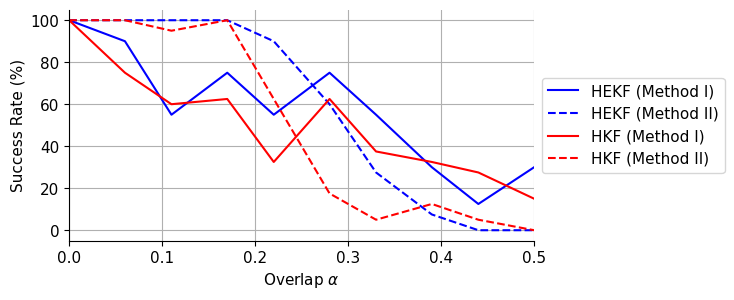

In [9]:
colors = ['b', 'r', 'g', 'k']

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(overlaps, success_2_curves_HEKF[:, 0], label=r"HEKF (Method I)", color=colors[0])
ax.plot(overlaps, success_2_curves_HEKF[:, 1], label=r"HEKF (Method II)", color=colors[0], linestyle='--')
ax.plot(overlaps, success_2_curves_HKF[:, 0], label=r"HKF (Method I)", color=colors[1])
ax.plot(overlaps, success_2_curves_HKF[:, 1], label=r"HKF (Method II)", color=colors[1], linestyle='--')

ax.set_ylabel("Success Rate (%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(overlaps[0], overlaps[-1])
ax.set_xlabel(r"Overlap $\alpha$")


fig.savefig(f"HEKF_{2}_curvess_success_rate_vs_overlap_ut_{ut}.pdf", dpi=300, bbox_inches='tight', format='pdf')

## PLOT 5 curves

In [10]:
success_5_curves_HEKF

array([[100., 100.],
       [ 99., 100.],
       [100., 100.],
       [ 97., 100.],
       [ 91., 100.],
       [ 82., 100.],
       [ 50., 100.],
       [ 30., 100.],
       [  8.,  98.],
       [  1.,  74.]])

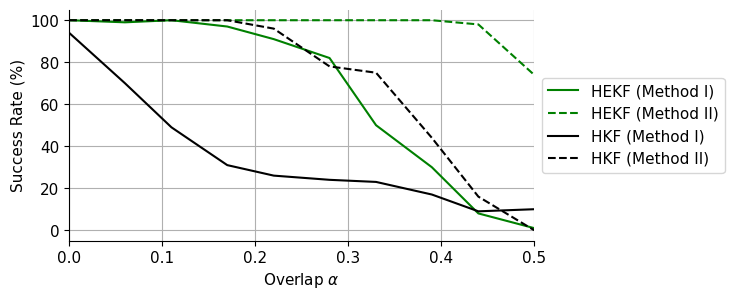

In [11]:
colors = ['b', 'r', 'g', 'k']

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(overlaps, success_5_curves_HEKF[:, 0], label=r"HEKF (Method I)", color=colors[2])
ax.plot(overlaps, success_5_curves_HEKF[:, 1], label=r"HEKF (Method II)", color=colors[2], linestyle='--')
ax.plot(overlaps, success_5_curves_HKF[:, 0], label=r"HKF (Method I)", color=colors[3])
ax.plot(overlaps, success_5_curves_HKF[:, 1], label=r"HKF (Method II)", color=colors[3], linestyle='--')

ax.set_ylabel("Success Rate (%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(overlaps[0], overlaps[-1])
ax.set_xlabel(r"Overlap $\alpha$")


fig.savefig(f"HEKF_{N_traces}_curvess_success_rate_vs_overlap_ut_{ut}.pdf", dpi=300, bbox_inches='tight', format='pdf')